# Monte Carlo and 2D Functions

In the last notebook, we saw how to draw random variates from a 1D distribution. For the final project, we need to perform a Monte Carlo simulation where we draw random variates from a 1D distribution that is interpolated from a 2D function.

In this notebook, we will work out an example of how to do this.

### First, import modules

In [1]:
# import modules
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Initialize an RNG

In [2]:
#imports the rng
from numpy.random import default_rng

#make a seed for reproducibility
seed = 1337

#create an instance of the rng
rng = default_rng(seed)

### Creating a 2D Function

In our numerical scheme, we want to represent a 2D function as a table. We plan to do this because we expect that evaluating the kernel $R(w,w')$ will be expensive, and so it makes sense to compute the function upfront and use interpolation to determine how to draw random variates from $R(w')$ at some $w$.

Let's pretend that $R(w,w')$ is a Gaussian in $w'$ with an RMS scatter $\sigma(w)$.  We will define $R(w,w')$ on a grid and precompute its values.

In [3]:
def sigma_w(w):
    #assume width depends on |w|
    return 0.5*(1. + np.fabs(w))

In [4]:
def R(w,wp):
    s = sigma_w(w)
    return 1./(2.*np.pi*s**2)**0.5 * np.exp(-0.5*(wp/s)**2)

#### OK, let's compute $R(w,w')$ for a range of $w$, $w'$.

In [5]:
#what is our range of w,w'?
w_min  = -10.0
w_max  =  10.0
wp_min = -30.0
wp_max =  30.0

#how many samples in each direction?
n_w  = 1001
n_wp = 1001

#produce arrays of w, w'
w = np.linspace(w_min,w_max,n_w)
wp = np.linspace(wp_min, wp_max, n_wp)

#get a grid with coordinates (w,w')
wx, wpy = np.meshgrid(w,wp)

#generate a 2D function R at (w,w') locations
Rwwp = R(wx,wpy)

### What does $R(w,w')$ look like?

Text(0, 0.5, "$w'$")

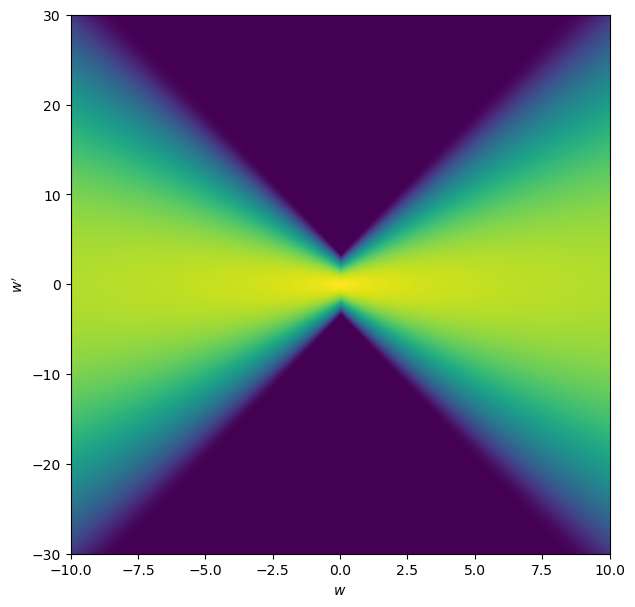

In [6]:
fig = plt.figure(figsize=(7,7))
plt.imshow(np.log(Rwwp+1.0e-9),extent=[-10,10,-30,30],origin="lower")
plt.gca().set_aspect(0.33333)
plt.xlabel(r'$w$')
plt.ylabel(r"$w'$")


### What does $R(w'|w)$ look like for a few values of $w$?

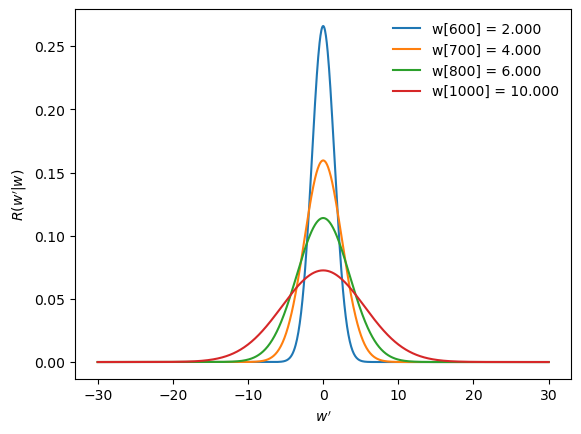

In [7]:

i = 600
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rwwp[:,i],label=s)

i = 700
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rwwp[:,i],label=s)
i = 800
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rwwp[:,i],label=s)

i = 1000
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rwwp[:,i],label=s)

plt.ylabel(r"$R(w'|w)$")
plt.xlabel(r"$w'$")

plt.legend(frameon=False)

### Converting PDF $\to$ CDF

For purposes of drawing random numbers, the CDF is more useful than the PDF. The function $R(w'|w)$, corresponding to the columns of the matrix we've computed above, are the PDFs of new frequencies $w'$ after scattering an incoming photon with frequency $w$.

Let's compute the running numerical integral of $R(w'|w)$.

In [8]:
Rint = np.zeros_like(Rwwp)

for i in range(n_w):
    for j in range(1,n_wp):
        Rint[j,i] = 0.5*(Rwwp[j-1,i] + Rwwp[j,i])*(wp[j]-wp[j-1]) + Rint[j-1,i]

Text(0, 0.5, "$w'$")

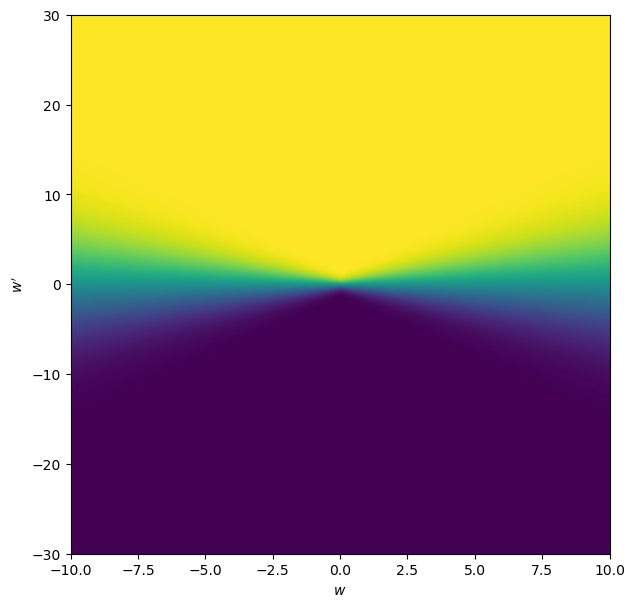

In [9]:
fig = plt.figure(figsize=(7,7))
plt.imshow(Rint,extent=[-10,10,-30,30],origin="lower")
plt.gca().set_aspect(0.33333)
plt.xlabel(r'$w$')
plt.ylabel(r"$w'$")


### What does $\int_{-\infty}^{w'} R(x|w)dx$ look like for a few values of $w$?

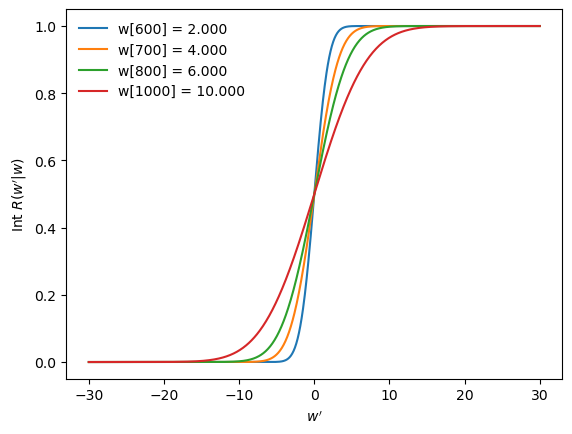

In [10]:

i = 600
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rint[:,i],label=s)

i = 700
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rint[:,i],label=s)
i = 800
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rint[:,i],label=s)

i = 1000
s = "w[%d] = %4.3f" % (i,w[i])
plt.plot(wp,Rint[:,i],label=s)

plt.ylabel(r"Int $R(w'|w)$")
plt.xlabel(r"$w'$")

plt.legend(frameon=False)

### How can we use this 2D function to draw variates in $w'$?

We now have the CDF of $w'$ tabulated for different values of $w$.  If we were interested in the value of the CDF for a given ($w$,$w'$) this would be great. We could use our 2D interpolation function to give us the CDF at that location. However, we want the $w'$ for a given $w$ and value for the CDF (pulled as a uniform variate $\xi_p \in [0,1]$).

#### Inverted 2D Interpolation

Our process is:
    
* Pull a random variate $\xi_p\in[0,1]$
* For our given $w$, find the index $i$ and $i+1$ for the bounding $w[i]$ and $w[i+1]$.
* Find the $j$ and $j+1$ where the CDF bounds $\xi_p$ for each of $i$ and $i+1$. Use these to define the subgrid containing $(w,\xi_p)$. This will in turn define $(x_0, x_1)$.
* Find $u$, and infer our $w'$.

Let's test our algorithm with a single value of $w$.

Text(0, 0.5, 'y')

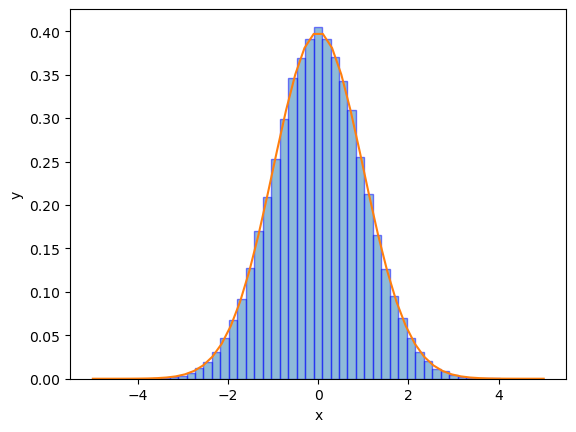

In [20]:
#how many random variates?
n_rand = 100000

#get the xi_p
xi_p = rng.uniform(0,1,n_rand)

#make our array of output wp values
wpc = np.zeros(n_rand)

#pick a fixed w
wc = 1 # should give a unit gaussian

#begin a loop over the random variates
for p in range(n_rand):
    
    #find the w indices bounding current w
    wi = np.searchsorted(w,wc,side="left")
    
    #define i, i+1
    i   = wi-1
    ip1 = wi
    
    
    #find the wp indices bounding xi_p
    
    wpi  = np.searchsorted(Rint[:,i],xi_p[p])
    wpia = np.searchsorted(Rint[:,ip1],xi_p[p])

    #define j, j+1 for each w
    j  = wpi-1
    ja = wpia-1
    
    #ensure the bounding box is large enough
    if(j>ja):
        ja = j
    elif(j<ja):
        j = ja
        
    jp1 = j+1
        
    #define t, z0, z1, z2, z3, and z
    t = (wc - w[i])/(w[ip1]-w[i])
    z0 = Rint[j,i]
    z1 = Rint[jp1,i]
    z2 = Rint[j,ip1]
    z3 = Rint[jp1,ip1]
    
    #find u
    u = (xi_p[p] - z2*t - z0*(1.-t))/((z1-z0)*(1.-t) + (z3-z2)*t)
    
    #get wp
    wpc[p] = u*(wp[jp1] - wp[j]) + wp[j]

    #how many bins to use?
nbins = 50

#matplotlib.pyplot.hist
n,bins,patches = plt.hist(wpc,bins=nbins,density=True,ec="blue",alpha=0.5)

#overplot a line
xx = np.linspace(-5,5,nbins)
yy = 1./(2.*np.pi)**0.5 * np.exp(-0.5*xx**2)


plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('y')

Text(0, 0.5, 'y')

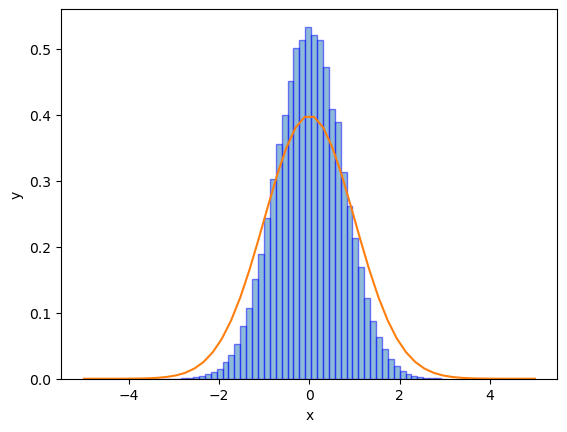

In [17]:
#how many bins to use?
nbins = 50

#matplotlib.pyplot.hist
n,bins,patches = plt.hist(wpc,bins=nbins,density=True,ec="blue",alpha=0.5)

#overplot a line
xx = np.linspace(-5,5,nbins)
yy = 1./(2.*np.pi)**0.5 * np.exp(-0.5*xx**2)


plt.plot(xx,yy)
plt.xlabel('x')
plt.ylabel('y')